# **Lab3 : Photo Mosaic using KNN Clustering**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Feature Preparation for tile images

Locate the directory containing your tile images dataset. Ensure that the images in this directory have a wide range of colors to create a visually appealing mosaic. List all the image filenames in the directory to `fnames`. ***Select a subset of these filenames to use as tile images, with at least 100 images in total, and assign them to `fnames_mini`.***

In [2]:
### START CODE HERE ###
image_directory = './image'  

fnames = glob.glob(os.path.join(image_directory, '*.jpg'))  

numImg = 100
fnames_mini = random.sample(fnames, min(numImg, len(fnames)))

print(f"Total images found: {len(fnames)}")
print(f"Subset of images selected: {len(fnames_mini)}")
### END CODE HERE ###

Total images found: 345
Subset of images selected: 100


In [3]:
assert len(fnames_mini) >= 100, "Less than 100 images found in the subset. Ensure the directory has at least 100 images."

### Loading and Resizing Tile Images
Define the size to which all tile images will be resized. This ensures consistency in the dimensions of the tile images. 
Iterate over the list of tile image filenames. Resize the image to the predefined `tile_size`. Append the processed image to the list of `tiles`.


In [4]:
### START CODE HERE ###
# Define the size to which all tile images will be resized
tile_size = (5, 5)  # Example size, adjust as needed

# Initialize an empty list to store the processed tile images
tiles = []

# Iterate over the list of tile image filenames
for fname in fnames_mini:
    # Load the image
    img = cv2.imread(fname)
    
    # Resize the image to the predefined tile size
    resized_img = cv2.resize(img, tile_size)
    
    # Append the processed image to the list of tiles
    tiles.append(resized_img)

print(f"Total tiles processed: {len(tiles)}")

### END CODE HERE ###

Total tiles processed: 100


In [5]:
assert len(tiles) == len(fnames_mini), "The number of processed images does not match the number of filenames. Ensure all images are loaded and processed correctly."

Randomly select a few tile images from your dataset and display them using Matplotlib. This will help you visually inspect the tile images to ensure they are loaded and processed correctly.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/1.png)
</details>

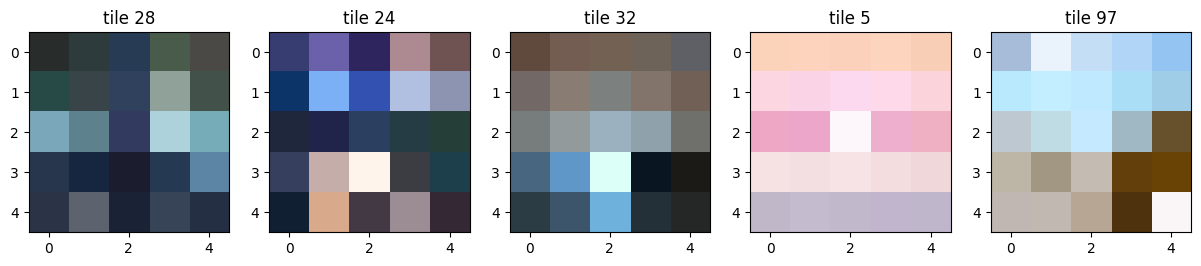

In [6]:
num_to_display = 5
indices = random.sample(range(len(tiles)), num_to_display)

# Retrieve the images corresponding to the selected indices
selected_images = [tiles[i] for i in indices]

fig, axs = plt.subplots(1, num_to_display, figsize=(15, 5))

for i in range(num_to_display):
    axs[i].imshow(selected_images[i])
    axs[i].set_title(f'tile {indices[i]}')

plt.show()
### END CODE HERE ###


Calculate the average color for each tile image and add the resulting mean color to the `colors` list.

In [7]:
### START CODE HERE ###
colors = []

# Iterate over each tile image
for tile in tiles:
    # Calculate the mean color of the tile
    mean_color = np.mean(tile, axis=(0, 1))
    
    # Append the mean color to the colors list
    colors.append(mean_color)

print(f"Total colors calculated: {len(colors)}")
print("Sample mean colors:", colors[:5])
### END CODE HERE ###


Total colors calculated: 100
Sample mean colors: [array([42.92, 58.92, 77.36]), array([ 97.36, 126.4 , 148.76]), array([135.04, 140.2 , 131.  ]), array([122.72, 120.12,  94.48]), array([175.44, 111.76, 139.92])]


Create a visual representation of the mean colors calculated for each tile image. 
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
- Example output where `numImg = 10`

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/2-1.png)

- Example output where `numImg = 500`

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/2-2.png)
</details>

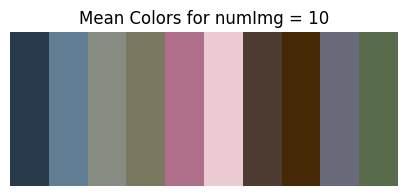

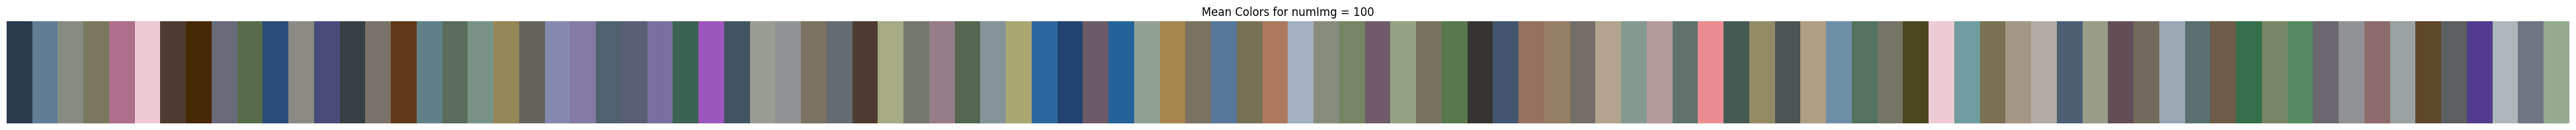

In [8]:
### START CODE HERE ###
# Number of colors to display in each row
def visualize_mean_colors(colors, numImg):
    colors_array = np.array(colors)
    
    if numImg > len(colors_array):
        numImg = len(colors_array)

    # Create a figure to display the colors
    fig, ax = plt.subplots(figsize=(numImg * 0.5, 2))  # Adjust figsize based on numImg

    # Create an array to represent colors as rectangles
    color_representation = np.zeros((1, numImg, 3), dtype=np.uint8)
    
    # Fill the color representation array
    color_representation[0] = colors_array[:numImg]

    # Display the color representation
    ax.imshow(color_representation, aspect='auto')

    # Set title and show plot
    plt.title(f'Mean Colors for numImg = {numImg}')
    plt.axis('off')  # Hide axes for better visual representation
    plt.show()

numImg_example = [10, len(tiles)]
for num in numImg_example:
    visualize_mean_colors(colors, num)
### END CODE HERE ###


## Preparation for main image

Load the main image.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/3.png)

</details>

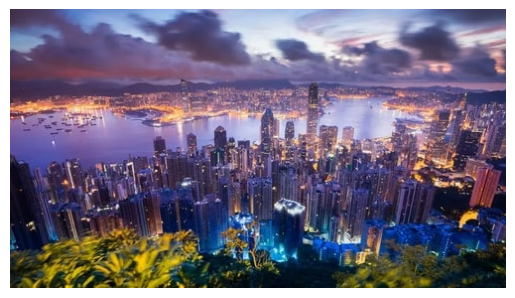

In [9]:
### START CODE HERE ###
# Path to the main image
main_image_path = './image/00169383-500.jpg'  # Replace with your actual image path

# Load the main image using OpenCV
og_img = cv2.imread(main_image_path)

# Check if the image is loaded successfully
if og_img is not None:
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    main_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
    
    # Display the main image using Matplotlib
    plt.imshow(main_img)
    plt.axis('off')  # Hide axes for better visual representation
    plt.show()
else:
    print(f"Failed to load image from {main_image_path}")
### END CODE HERE ###


Compute the number of tiles required in the height and width dimensions of the image. This is based on the size of each tile and the dimensions of the original image. Define the dimensions for the resized image grid.

In [10]:
class Mosaic:
    def __init__(self, og_img, main_img, tiles):
        self.tiles = tiles
        self.og_img = og_img
        self.main_img = main_img
        self.tiles = tiles
        self.colors = None
        self.img_mean_colors = np.zeros((self.get_main_img_size()[0], self.get_main_img_size()[1], 3), dtype=np.float32)
        self.tree = None
        self.closest_tiles = np.zeros(self.get_main_img_size(), dtype=int) #เก็บตำแหน่ง index ของภาไที่มี average ใกล้กับจุดนั้นๆ
        self.mosaic_img = np.zeros((self.get_og_img_size()[0], self.get_og_img_size()[1], 3), dtype=np.uint8) 

    def get_og_img_size(self):
        og_height, og_width, _ = self.og_img.shape
        return (og_height, og_width)

    def get_main_img_size(self):
        num_tiles_y = int(self.get_og_img_size()[0] // self.get_tiles_size()[0])
        num_tiles_x = int(self.get_og_img_size()[1] // self.get_tiles_size()[1])
        return (num_tiles_y, num_tiles_x)
    
    def get_tiles_size(self):
        tile_height, tile_width, _ = self.tiles[0].shape
        return (tile_height, tile_width)

    def get_tiles(self):
        return self.tiles

    def get_og_img(self):
        return self.og_img

    def get_main_img(self):
        return self.main_img

    def get_colors(self):
        return self.colors

    def get_img_mean_colors(self):
        return self.get_img_mean_colors

    def get_tree(self):
        return self.tree

    def get_closest_tiles(self):
        return self.closest_tiles

    def get_mosaic_img(self):
        return self.mosaic_img

    def create_tiles_mean_colors(self):
        mean_color_each_tile = [self.compute_mean_color(tile) for tile in tiles]
        self.colors = np.array(mean_color_each_tile)

    def compute_mean_color(self, img):
        return np.mean(img, axis=(0, 1))

    def create_KDTree(self):
        self.create_tiles_mean_colors()
        # Build KD-Tree from mean colors of tiles
        self.tree = spatial.KDTree(self.colors)

    def create_closest_tiles_with_k(self, k):
        # Initialize the closest_tiles matrix
        self.create_KDTree()
        channels = cv2.split(self.og_img)
        # Convert image to the same format as mean colors (flattened)
        self.img_mean_colors = np.zeros((self.get_main_img_size()[0], self.get_main_img_size()[1], len(channels)), dtype=np.float32)
        self.closest_tiles = np.zeros(self.get_main_img_size(), dtype=int)
        for i in range(self.get_main_img_size()[0]):
            for j in range(self.get_main_img_size()[1]):
                # Extract the current tile region from the image and compute its mean color
                tile_region = self.og_img[i * self.get_tiles_size()[0]:(i + 1) * self.get_tiles_size()[0], j * self.get_tiles_size()[1]:(j + 1) * self.get_tiles_size()[1]]
                self.img_mean_colors[i, j] = self.compute_mean_color(tile_region)

                # Query the KD-Tree to find the closest tiles by mean color
                distances, indices = self.tree.query(self.img_mean_colors[i, j], k = k)

                if k == 1:
                    # For k=1, directly assign the closest tile index
                    self.closest_tiles[i, j] = indices
                else:
                    # For k>1, perform voting to choose the most frequent tile index
                    # Count occurrences of each index
                    if i==1 and j==1:
                        print(len(indices))
                    vote_counts = np.bincount(indices)
                    most_common_index = np.argmax(vote_counts)
                    self.closest_tiles[i, j] = most_common_index

    def draw_mosaic(self, k):
        self.create_closest_tiles_with_k(k=k)
        self.mosaic_img = np.zeros((self.get_og_img_size()[0], self.get_og_img_size()[1], 3), dtype=np.uint8) 
        for i in range(self.get_main_img_size()[0]):
            for j in range(self.get_main_img_size()[1]):
                x,y = j * self.get_tiles_size()[1], i * self.get_tiles_size()[0]
                # Index of tile
                index = self.closest_tiles[i, j]
                # Draw tile
                self.mosaic_img[y:y + self.get_tiles_size()[0], x:x + self.get_tiles_size()[1], :] = self.tiles[index]
        return self.mosaic_img, self.closest_tiles

Visualize the resized image to ensure proper alignment with the tile grid.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/4.png)

</details>

In [11]:
### START CODE HERE ###
mosaic = Mosaic(og_img, main_img, tiles)
print(f"Original Image Dimensions: Height = {mosaic.get_og_img_size()[0]}, Width = {mosaic.get_og_img_size()[1]}")
print(f"Tile Size: {mosaic.get_tiles_size()}")
print(f"Main Image Dimensions: Height = {mosaic.get_main_img_size()[0]}, Width = {mosaic.get_main_img_size()[1]}")

### END CODE HERE ###

Original Image Dimensions: Height = 281, Width = 500
Tile Size: (5, 5)
Main Image Dimensions: Height = 56, Width = 100


Create a KDTree from the list of mean colors of the tile images using [`spatial.KDTree()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html). Use `closest_tiles` to store the index of the closest tile image for each pixel in the resized main image.
***Try with difference value of k in `tree.query()`***

(56, 100, 3)


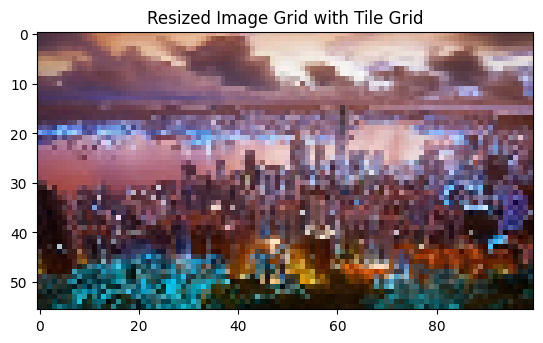

In [12]:
### START CODE HERE ###
main_img = cv2.resize(og_img, (mosaic.get_main_img_size()[1], mosaic.get_main_img_size()[0]), interpolation=cv2.INTER_NEAREST) #This means that the value of each pixel in the resized image is taken from the closest pixel in the original image without any smoothing or blending.
print(main_img.shape)
plt.imshow(main_img)
plt.title('Resized Image Grid with Tile Grid')
plt.show()
### END CODE HERE ###

In [13]:
_, closest_tiles = mosaic.draw_mosaic(k=1)
print(closest_tiles.shape)

assert closest_tiles.shape == mosaic.get_closest_tiles().shape, "The shape of the closest_tiles array does not match the expected dimensions."

(56, 100)


Visualizing `closest_tiles` Indices
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/5.png)

</details>

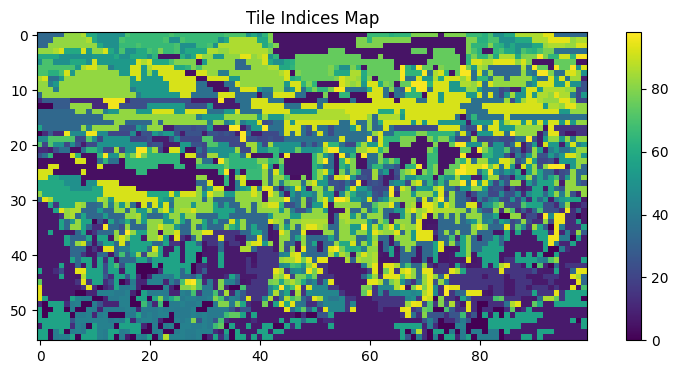

In [14]:
### START CODE HERE ###
plt.figure(figsize=(10, 4))
plt.imshow(closest_tiles)
plt.colorbar()
plt.title('Tile Indices Map')
plt.axis('on')
plt.show()
### END CODE HERE ###

Create a copy of the resized main image and replace each pixel region with the corresponding tile image based on the closest tile indices to assemble the final photo mosaic.

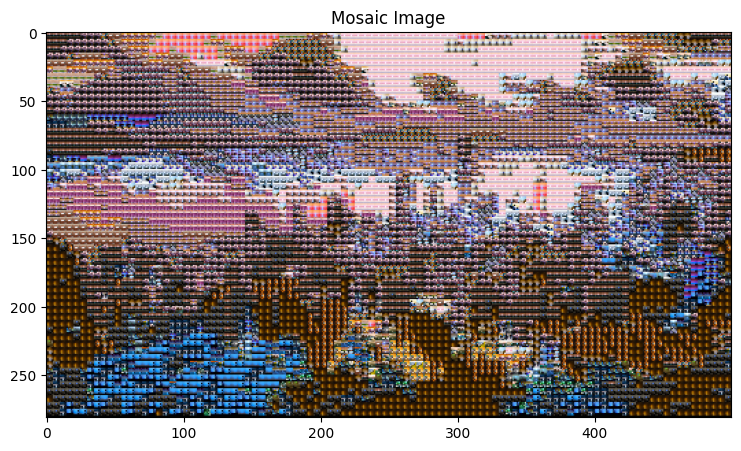

In [15]:
### START CODE HERE ###
mosaic_img,_ = mosaic.draw_mosaic(k=1)

# Display the mosaic
plt.figure(figsize=(10, 5))
plt.imshow(mosaic_img)
plt.title('Mosaic Image')
plt.show()
### END CODE HERE ###

Create a side-by-side comparison of four images: the original image, the resized main image, the final mosaic, and the KDTree tile index grid. This helps visualize the mosaic creation process.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/6.png)

</details>

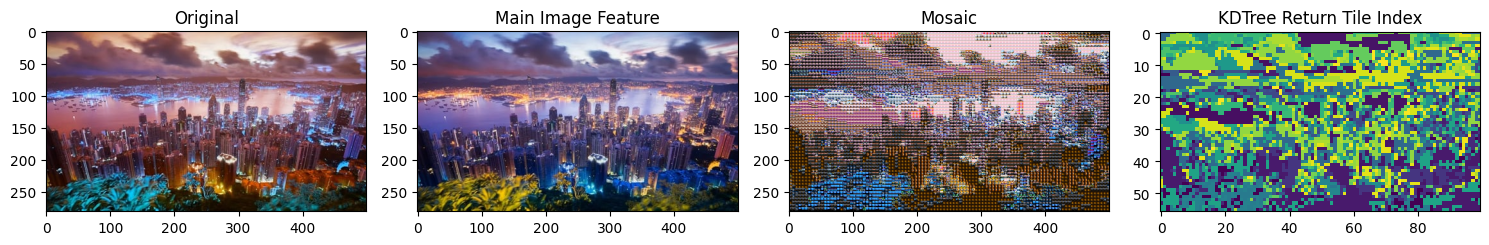

In [16]:
### START CODE HERE ###

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(mosaic.og_img)
axs[0].set_title('Original')

axs[1].imshow(mosaic.main_img)
axs[1].set_title('Main Image Feature')

axs[2].imshow(mosaic_img)
axs[2].set_title('Mosaic')

axs[3].imshow(closest_tiles)
axs[3].set_title('KDTree Return Tile Index')

plt.tight_layout()
plt.show()
### END CODE HERE ###

## Save the final photo mosaic 
Experiment with at least 3 different values of k and save the final photo.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- Saved output should resemble this, but not be identical

![image.gif](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab3_Image-Clustering/asset/7.gif?raw=true)


- k = 1

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k1.png)

- k = 10

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k10.png)

- k = 50

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k50.png)
</details>

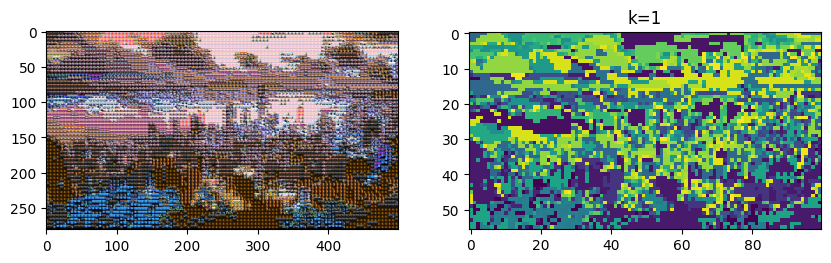

10


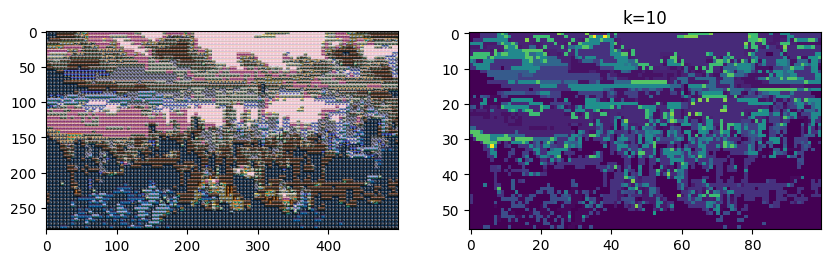

50


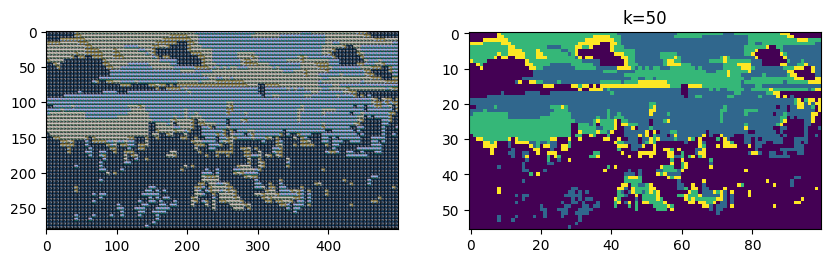

In [17]:
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
### START CODE HERE ###
k_list = [1, 10, 50]
for i in k_list:
    mosaic_img_ki, closest_tiles_ki = mosaic.draw_mosaic(k=i)

    output_file = os.path.join(output_folder, f"mosaic_k{i}.jpg")
    cv2.imwrite(output_file, cv2.cvtColor(mosaic_img_ki, cv2.COLOR_RGB2BGR))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(mosaic_img_ki)
    axs[1].imshow(closest_tiles_ki)
    plt.title(f'k={i}')
    plt.show()
### END CODE HERE ###

## **Question** 
1. How does changing the size of the tiles influence the overall quality and appearance of the mosaic? Conduct an analysis comparing two different tile sizes and discuss the trade-offs involved in terms of computational complexity and visual fidelity.
2. Explain the effect of changing the value of K (number of nearest neighbors) on the mosaic image.